In [1]:
using HDF5
using FastGaussQuadrature
using LaTeXStrings
using LinearAlgebra
using Particles
using Plots
using Random
using ReducedBasisMethods
using Statistics

In [2]:
fpath = "../runs/BoT_Np5e4_k_010_050_np_10_T25.h5"

params = read_sampling_parameters(fpath)

μₜᵣₐᵢₙ = h5read(fpath, "parameters/mu_train")

IP = IntegratorParameters(fpath)

poisson = PoissonSolverPBSplines(fpath)

X = h5read(fpath, "snapshots/X");
V = h5read(fpath, "snapshots/V");
E = h5read(fpath, "snapshots/E");
# D = h5read(fpath, "snapshots/D");
# Φ = h5read(fpath, "snapshots/Phi");

In [3]:
# Reference draw
P₀ = ParticleList(X[:,1], V[:,1], ones(IP.nₚ) .* poisson.L ./ IP.nₚ);

In [4]:
params

(κ = 0.3, ε = 0.03, a = 0.1, v₀ = 4.5, σ = 0.5, χ = 1.0)

In [5]:
μₜᵣₐᵢₙ

10×5 Matrix{Float64}:
 0.1       0.03  0.1  4.5  0.5
 0.144444  0.03  0.1  4.5  0.5
 0.188889  0.03  0.1  4.5  0.5
 0.233333  0.03  0.1  4.5  0.5
 0.277778  0.03  0.1  4.5  0.5
 0.322222  0.03  0.1  4.5  0.5
 0.366667  0.03  0.1  4.5  0.5
 0.411111  0.03  0.1  4.5  0.5
 0.455556  0.03  0.1  4.5  0.5
 0.5       0.03  0.1  4.5  0.5

# EVD

In [6]:
# XV = hcat(X, V);
XV = copy(X)
for p in 1:IP.nparam
    # XV = hcat(XV, V[:,1+(p-1)*IP.nₛ])
    global XV = hcat(XV, V[:,1+(p-1)*IP.nₛ]) #, E[:,p*IP.nₛ])
    #print(1+(p-1)*IP.nₛ, " ", p*IP.nₛ, "\n" )
end

In [7]:
# clear 
X, V = 0, 0
GC.gc()

In [8]:
size(XV)

(5000, 2520)

In [9]:
# @time F = eigen(Xₑₓₜ' * Xₑₓₜ);
# Λ, Ω = sorteigen(F.values, F.vectors);
@time F = eigen(XV' * XV);
Λ, Ω = sorteigen(F.values, F.vectors);
@time Fₑ = eigen(E' * E);
Λₑ, Ωₑ = sorteigen(Fₑ.values, Fₑ.vectors);

 11.459687 seconds (3.86 M allocations: 407.282 MiB, 0.44% gc time, 26.47% compilation time)


  4.658265 seconds (20 allocations: 193.165 MiB)


In [10]:
# clear
F, Fₑ = 0, 0
GC.gc()

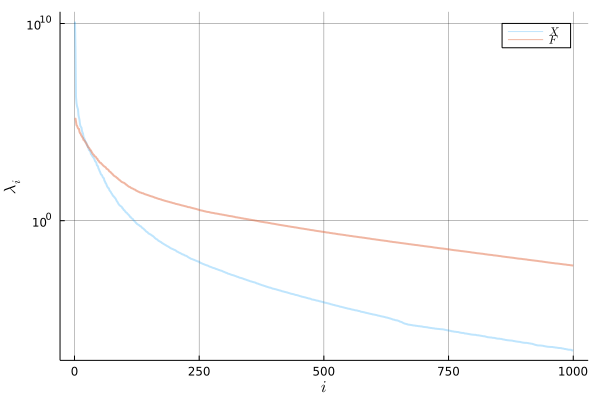

In [11]:
plot(xlabel = L"$i$", ylabel = L"$\lambda_i$", yscale = :log10, 
     grid = true, gridalpha = 0.5)
plot!(abs.(Λ )[1:1000], linewidth = 2, alpha = 0.25, label = L"$X$")
plot!(abs.(Λₑ)[1:1000], linewidth = 2, alpha = 0.5,  label = L"$F$")
#savefig("../Presentations/SVDs_BoT.pdf")

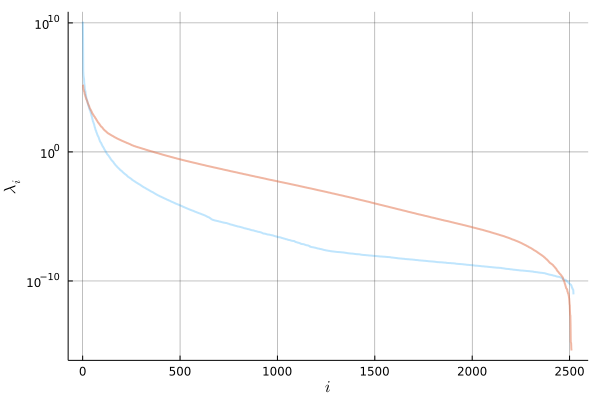

In [12]:
plot(xlabel = L"$i$", ylabel = L"$\lambda_i$", yscale = :log10, 
     grid = true, gridalpha = 0.5, legend = :none)
plot!(abs.(Λ ), linewidth = 2, alpha = 0.25, label = L"$X_v$")
plot!(abs.(Λₑ), linewidth = 2, alpha = 0.5,  label = L"$E$")

# Projection Matrices

In [13]:
k, Ψ = get_Ψ(XV, Λ, Ω, 1e-9, 0)
k

131

In [14]:
kₑ, Ψₑ = get_Ψ(E, Λₑ, Ωₑ, 1e-5, 0)
kₑ

637

In [15]:
# # clear 
XV, E = 0, 0
Λ, Λₑ, Ω, Ωₑ = 0, 0, 0, 0
GC.gc()

# DEIM

In [16]:
@time Πₑ = deim_get_Π(Ψₑ);

 20.903379 seconds (5.60 M allocations: 1.614 GiB, 1.58% gc time, 12.83% compilation time)


In [17]:
h5save("../runs/BoT_Np5e4_k_010_050_np_10_T25_projections.h5", IP, poisson, params, μₜᵣₐᵢₙ, k, kₑ, Ψ, Ψₑ, Πₑ, P₀);